## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl

In [3]:
from nam.data import *
from nam.config import defaults
from nam.models import NAM, DNN, get_num_units
from nam.engine import Engine

## Configuration 

In [4]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, training_epochs=10, units_multiplier=2, use_dnn=False)


In [5]:
pl.seed_everything(config.seed)

Global seed set to 1377


1377

## Dataset & Dataloaders (California Housing Dataset)

In [171]:
# dataset = load_sklearn_housing_data(config=config) 
dataset = load_breast_data(config=config)
# dataset = load_gallup_data(
#     config=config,
#     features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"]
# )

In [172]:
len(dataset.data)

569

In [8]:
dataset.features.shape

torch.Size([569, 30])

In [9]:
dataset.targets.max().item()

1

In [10]:
dataset.targets.shape

torch.Size([569])

In [11]:
train_dls = dataset.train_dataloaders()

In [12]:
test_dl = dataset.test_dataloaders()

## NAM Model

In [13]:
model = NAM(
      config=config,
      name="NAMModel_Housing",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
      num_outputs=int(dataset.targets.max().item() + 1),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=912)
        (1): LinReLU(in_features=912, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=958)
        (1): LinReLU(in_features=958, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features

In [14]:
train_dl, val_dl = next(train_dls)
x, y = next(iter(train_dl))

2021-04-03 11:37:12.192 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[1]: train: 398, val: 57


In [15]:
logits, fnn_out = model(x)
logits

tensor([[0.6435, 0.3565],
        [0.2119, 0.7881],
        [0.4327, 0.5673],
        [0.6948, 0.3052],
        [0.7344, 0.2656],
        [0.4567, 0.5433],
        [0.6918, 0.3082],
        [0.2143, 0.7857],
        [0.5082, 0.4918],
        [0.4094, 0.5906],
        [0.5063, 0.4937],
        [0.4657, 0.5343],
        [0.4243, 0.5757],
        [0.5774, 0.4226],
        [0.7249, 0.2751],
        [0.4689, 0.5311],
        [0.0685, 0.9315],
        [0.7875, 0.2125],
        [0.6188, 0.3812],
        [0.6497, 0.3503],
        [0.5743, 0.4257],
        [0.3398, 0.6602],
        [0.4429, 0.5571],
        [0.4670, 0.5330],
        [0.3549, 0.6451],
        [0.3530, 0.6470],
        [0.1001, 0.8999],
        [0.2582, 0.7418],
        [0.4570, 0.5430],
        [0.5063, 0.4937],
        [0.8384, 0.1616],
        [0.2165, 0.7835],
        [0.3586, 0.6414],
        [0.2851, 0.7149],
        [0.0498, 0.9502],
        [0.7625, 0.2375],
        [0.3203, 0.6797],
        [0.4867, 0.5133],
        [0.3

In [16]:
pl.metrics.functional.accuracy(logits, y)

tensor(0.5528)

## Training

In [17]:
engine = Engine(config, model)
# engine

In [18]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory output/NAMModel_Housing/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [19]:
while True:
    try:
        train_dl, val_dl = next(train_dls)
        trainer = pl.Trainer(
            default_root_dir=f"{config.output_dir}/{model.name}",
            max_epochs=config.training_epochs,
            callbacks=[checkpoint_callback],
        )
        trainer.fit(model=engine, train_dataloader=train_dl, val_dataloaders=val_dl)
    except StopIteration:
        break

2021-04-03 11:37:13.502 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[2]: train: 398, val: 57
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 2.0 M 
1 | metrics | Accuracy | 0     
-------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:37:20.028 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[3]: train: 398, val: 57
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 2.0 M 
1 | metrics | Accuracy | 0     
-------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:37:26.421 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[4]: train: 398, val: 57
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 2.0 M 
1 | metrics | Accuracy | 0     
-------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:37:32.970 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[5]: train: 398, val: 57
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 2.0 M 
1 | metrics | Accuracy | 0     
-------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [20]:
engine.metrics.compute()

tensor(0.8442)

## Testing

In [21]:
trainer.test(model=engine, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9298245906829834,
 'test_acc_epoch': 0.9298245906829834,
 'test_loss': 0.38971394300460815,
 'test_loss_epoch': 0.38971394300460815}
--------------------------------------------------------------------------------


[{'test_loss': 0.38971394300460815,
  'test_loss_epoch': 0.38971394300460815,
  'test_acc_epoch': 0.9298245906829834,
  'test_acc': 0.9298245906829834}]

---
---
---

## Dataset & Dataloaders (Breast Cancer Dataset)

In [11]:
dataset = load_sklearn_housing_data(config=config) 
# dataset = load_breast_data(config=config)
# dataset = load_gallup_data(
#     config=config,
#     features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"]
# )

In [12]:
len(dataset.data)

20640

In [13]:
dataset.features.shape

torch.Size([20640, 8])

In [14]:
dataset.targets.max().item()

5.000010013580322

In [15]:
dataset.targets.shape

torch.Size([20640])

In [16]:
train_dls = dataset.train_dataloaders()

In [17]:
test_dl = dataset.test_dataloaders()

## NAM Model

In [18]:
model = NAM(
      config=config,
      name="NAMModel_Breast",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
#       num_outputs=int(dataset.targets.max().item() + 1),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=104)
        (1): LinReLU(in_features=104, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_featur

## Training

In [19]:
engine = Engine(config, model)
# engine

In [20]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

In [21]:
while True:
    try:
        train_dl, val_dl = next(train_dls)
        trainer = pl.Trainer(
            default_root_dir=f"{config.output_dir}/{model.name}",
            max_epochs=config.training_epochs,
            callbacks=[checkpoint_callback],
        )
        trainer.fit(model=engine, train_dataloader=train_dl, val_dataloaders=val_dl)
    except StopIteration:
        break

2021-04-03 11:41:22.271 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[1]: train: 14448, val: 2064
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type              | Params
----------------------------------------------
0 | model   | NAM               | 486 K 
1 | metrics | MeanAbsoluteError | 0     
----------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:41:52.346 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[2]: train: 14448, val: 2064
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type              | Params
----------------------------------------------
0 | model   | NAM               | 486 K 
1 | metrics | MeanAbsoluteError | 0     
----------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:42:23.448 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[3]: train: 14448, val: 2064
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type              | Params
----------------------------------------------
0 | model   | NAM               | 486 K 
1 | metrics | MeanAbsoluteError | 0     
----------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:42:54.981 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[4]: train: 14448, val: 2064
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type              | Params
----------------------------------------------
0 | model   | NAM               | 486 K 
1 | metrics | MeanAbsoluteError | 0     
----------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 11:43:26.670 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[5]: train: 14448, val: 2064
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type              | Params
----------------------------------------------
0 | model   | NAM               | 486 K 
1 | metrics | MeanAbsoluteError | 0     
----------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Testing

In [22]:
trainer.test(model=engine, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6769142746925354,
 'test_acc_epoch': 0.8297551870346069,
 'test_loss': 0.6098895072937012,
 'test_loss_epoch': 1.2295547723770142}
--------------------------------------------------------------------------------


[{'test_loss': 0.6098895072937012,
  'test_loss_epoch': 1.2295547723770142,
  'test_acc_epoch': 0.8297551870346069,
  'test_acc': 0.6769142746925354}]

---
---
---

## Dataset & Dataloaders (GALLUP Dataset)

In [6]:
# dataset = load_sklearn_housing_data(config=config) 
# dataset = load_breast_data(config=config)
dataset = load_gallup_data(
    config=config,
    features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"]
)

In [7]:
len(dataset.data)

1340809

In [8]:
dataset.features.shape

torch.Size([1340809, 4])

In [9]:
dataset.targets.max().item()

1

In [10]:
dataset.targets.shape

torch.Size([1340809])

In [11]:
config.batch_size = 2048

In [12]:
train_dls = dataset.train_dataloaders()

In [13]:
test_dl = dataset.test_dataloaders()

## NAM Model

In [14]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
      num_outputs=int(dataset.targets.max().item() + 1),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=176)
        (1): LinReLU(in_features=176, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, 

## Training

In [15]:
config.training_epochs = 1

In [16]:
engine = Engine(config, model)
# engine

In [17]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory output/NAMModel_GALLUP/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [18]:
while True:
    try:
        train_dl, val_dl = next(train_dls)
        trainer = pl.Trainer(
            default_root_dir=f"{config.output_dir}/{model.name}",
            max_epochs=config.training_epochs,
            callbacks=[checkpoint_callback],
        )
        trainer.fit(model=engine, train_dataloader=train_dl, val_dataloaders=val_dl)
    except StopIteration:
        break

2021-04-03 15:14:43.628 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[1]: train: 938566, val: 134081
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 152 K 
1 | metrics | Accuracy | 0     
-------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.610     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 15:15:48.469 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[2]: train: 938566, val: 134081
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 152 K 
1 | metrics | Accuracy | 0     
-------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.610     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 15:16:54.596 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[3]: train: 938566, val: 134081
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 152 K 
1 | metrics | Accuracy | 0     
-------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.610     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 15:18:01.110 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[4]: train: 938566, val: 134081
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 152 K 
1 | metrics | Accuracy | 0     
-------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.610     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-04-03 15:19:07.068 | INFO     | nam.data.folded:train_dataloaders:113 - Fold[5]: train: 938566, val: 134081
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 152 K 
1 | metrics | Accuracy | 0     
-------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.610     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Testing

In [19]:
trainer.test(model=engine, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.634235143661499,
 'test_acc_epoch': 0.5745929479598999,
 'test_loss': 0.672409176826477,
 'test_loss_epoch': 0.6738706231117249}
--------------------------------------------------------------------------------


[{'test_loss': 0.672409176826477,
  'test_loss_epoch': 0.6738706231117249,
  'test_acc_epoch': 0.5745929479598999,
  'test_acc': 0.634235143661499}]

---
---
---

In [173]:
from nam.data.base import NAMDataset

In [174]:
config.regression = False

In [175]:
csv_file = 'data/GALLUP.csv'
data = pd.read_csv(csv_file)
data["WP16"] = np.where(data["WP16"]<6, 0, 1)
data.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,0,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,1,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [205]:
data = data.sample(frac=0.1)

In [204]:
data = df

In [206]:
data.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
986236,1,0.340017,50,0.000056,1.0,0.545455,2,0.293860
856649,1,0.141588,100,0.000044,1.0,0.465909,3,0.222797
894727,1,0.049310,50,0.000066,1.0,0.488636,2,0.293860
818690,0,0.063330,102,0.000003,0.0,0.386364,1,0.001924
1238291,0,0.059157,74,0.000004,1.0,0.727273,3,0.015416


In [207]:
len(data)

131980

In [208]:
features_columns = list(df.columns)[2:]# ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp",  "year"]
targets_column = "WP16"
weights_column = "wgt"
dataset = NAMDataset(
  config=config,
  file_path=data,
  features_columns=features_columns,
  targets_column=targets_column,
  weights_column=weights_column,
)

In [209]:
dataset

NAMDatasetSample(
	features=tensor([-0.5425, -1.0000, -1.0000, -0.6471, -1.0000, -0.9715]), 
	targets=1, 
	weights=0.32838284969329834
)

In [210]:
len(dataset)

131980

In [211]:
config.hidden_sizes = [16]

In [212]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
      num_outputs=int(dataset.targets.max().item() + 1),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=308)
        (1): LinReLU(in_features=308, out_features=16)
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=16)
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=16)
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=172)
        (1): LinReLU(in_features=172, out_features=16)
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (Feature

In [213]:
total_count = len(dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_count, valid_count, test_count)
)


train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers
)
valid_dataset_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers
)
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers
)
dataloaders = {
    "train": train_dataset_loader,
    "val": valid_dataset_loader,
    "test": test_dataset_loader,
}

In [214]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9891790e10>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f9888593490>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f98885c0e90>}

In [215]:
engine = Engine(config, model)

In [216]:
config.training_epochs = 3

In [217]:
trainer = pl.Trainer(
    default_root_dir=f"{config.output_dir}/{model.name}",
    max_epochs=config.training_epochs,
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [218]:
trainer.fit(model=engine, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])


  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 45.2 K
1 | metrics | Accuracy | 0     
-------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [219]:
trainer.test(model=engine, test_dataloaders=dataloaders['test'])

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5769230723381042,
 'test_acc_epoch': 0.5798605680465698,
 'test_loss': 0.667184591293335,
 'test_loss_epoch': 0.6670439839363098}
--------------------------------------------------------------------------------


[{'test_loss': 0.667184591293335,
  'test_loss_epoch': 0.6670439839363098,
  'test_acc_epoch': 0.5798605680465698,
  'test_acc': 0.5769230723381042}]

---
---
---

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [82]:
y=data.iloc[:,0].values

In [83]:
data = data.drop('country', axis=1)
data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [84]:
data.head(3)

,WP16,wgt,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,-0.655362,1.184700,-0.007673,-1.065434,-1.488956,1.344815,0.642051
1,-0.655362,2.010882,-0.012368,-1.065434,-1.488956,0.075571,0.575457
2,1.074004,0.686555,-0.003729,-1.065434,-1.488956,0.921734,0.610033


In [85]:
x= data.iloc[:,1:].values
# y=data.iloc[:,0].values
x, y

(array([[ 1.1846996 , -0.00767343, -1.06543378, -1.48895611,  1.34481481,
          0.64205117],
        [ 2.0108822 , -0.01236773, -1.06543378, -1.48895611,  0.075571  ,
          0.57545723],
        [ 0.68655482, -0.00372865, -1.06543378, -1.48895611,  0.92173354,
          0.61003285],
        ...,
        [ 0.42526419, -0.02382686, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ],
        [-0.52427233, -0.02125759, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ],
        [-0.04950407,  0.00828902, -1.06543378,  3.28267659, -0.77059155,
         -0.9470326 ]]),
 array([4, 4, 8, ..., 5, 5, 7]))

In [86]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

In [87]:
y

array([4, 4, 8, ..., 5, 5, 7])

In [12]:
data.columns

Index(['WP16', 'wgt', 'income_2', 'WP1219', 'WP1220', 'year',
       'weo_gdpc_con_ppp'],
      dtype='object')

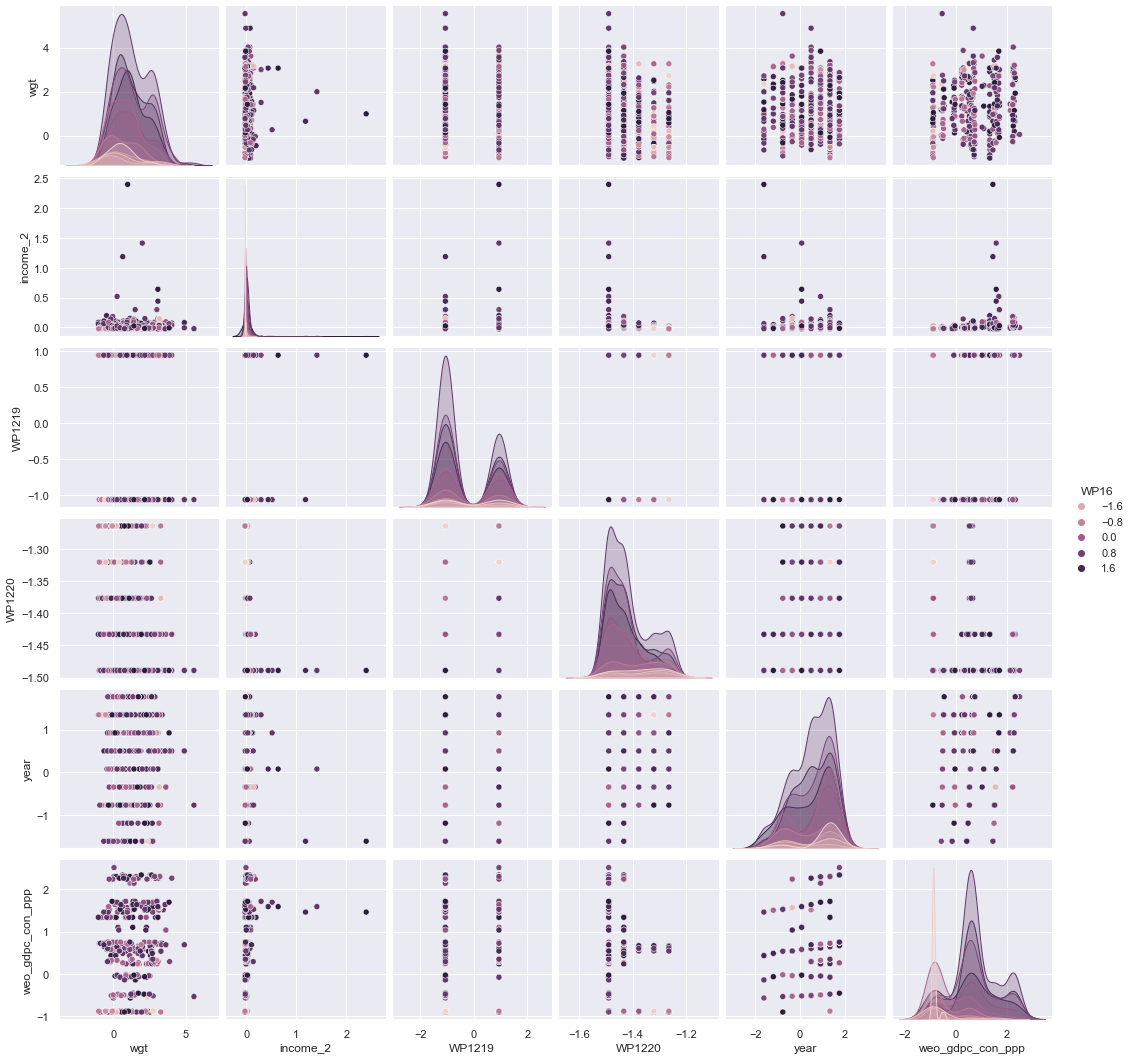

In [14]:
sns.set()
sns.pairplot(data[:1000], hue="WP16", diag_kind="kde")

In [88]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

y_pred_test = gnb.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred_test)

In [17]:
acc

0.1334305382567254

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

y_pred2 = dt.predict(x_test)
acc2 = accuracy_score(y_test,y_pred2)
acc2

0.17982040706736974

In [20]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')

clf.fit(x_train,y_train)
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
acc3

0.1614882048910733

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     

svc1.fit(x_train,y_train)
y_pred4 = svc1.predict(x_test)

from sklearn.metrics import accuracy_score
acc4=    accuracy_score(y_test,y_pred4)
acc4

In [74]:
import numpy as np
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils
from sklearn.model_selection import train_test_split

# #loading data
# df = dsutils.load_bank()
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# y = df_train.pop('y')
# y_test = df_test.pop('y')

# #training
# config = deeptable.ModelConfig(nets=deepnets.DeepFM)
# dt = deeptable.DeepTable(config=config)
# model, history = dt.fit(df_train, y, epochs=10)

# #evaluation
# result = dt.evaluate(df_test,y_test, batch_size=512, verbose=0)
# print(result)

# #scoring
# preds = dt.predict(df_test)

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/GALLUP.csv')
data.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [82]:
y=data.iloc[:,0].values

In [93]:
# data = data.drop('country', axis=1)
# data =(data-data.mean())/data.std()
data = data.interpolate(method='linear', axis=0)

In [94]:
data.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [159]:
data = df

In [160]:
x= data.iloc[:,1:].values
y=data.iloc[:,0].values
x, y

(array([[2.29189379e-01, 2.00914198e-05, 0.00000000e+00, 2.27272727e-02,
         2.20877965e-01],
        [3.03079114e-01, 1.42527095e-05, 0.00000000e+00, 2.27272727e-02,
         2.12001751e-01],
        [1.84637744e-01, 2.49978784e-05, 0.00000000e+00, 2.27272727e-02,
         2.16610287e-01],
        ...,
        [1.61269186e-01, 0.00000000e+00, 0.00000000e+00, 9.88636364e-01,
         9.07118490e-03],
        [7.63472800e-02, 3.19562384e-06, 0.00000000e+00, 9.88636364e-01,
         9.07118490e-03],
        [1.18808233e-01, 3.99452980e-05, 0.00000000e+00, 9.88636364e-01,
         9.07118490e-03]]),
 array([0, 0, 1, ..., 0, 0, 1]))

In [161]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
y = ly.fit_transform(y)

In [162]:
y

array([0, 0, 1, ..., 0, 0, 1])

In [163]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [164]:
x_train.shape, y_train.shape

((1072647, 5), (1072647,))

In [165]:
#training
config = deeptable.ModelConfig(nets=deepnets.DeepFM, 
                              categorical_columns='auto', # or categorical_columns=['x1', 'x2', 'x3', ...]
                                metrics=['AUC', 'accuracy'], # can be `metrics=['RootMeanSquaredError']` for regression task
                                auto_categorize=True,
                                auto_discrete=False,
                                embeddings_output_dim=20,
                                embedding_dropout=0.3,)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(x_train, y_train, batch_size=2048, epochs=3)

#evaluation
result = dt.evaluate(x_test,y_test, batch_size=1024, verbose=0)
print(result)

#scoring
preds = dt.predict(x_test)

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4'], dtype='object')


2 class detected, {0, 1}, so inferred as a [binary classification] task
Preparing features taken 1.1357131004333496s
Imputation taken 1.076157808303833s
Categorical encoding taken 0.8838996887207031s
Injected a callback [EarlyStopping]. monitor:val_auc, patience:1, mode:max
>>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (2)', 'input_continuous_all: (5)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [4, 90]
output_dims: [20, 20]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 45)
---------------------------------------------------------
nets: ['fm_nets', 'dnn_nets', 'linear']
---

Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4'], dtype='object')


Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
Model has been saved to:dt_output/dt_20210403 145648_fm_nets_dnn_nets_linear/fm_nets+dnn_nets+linear.h5


Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4'], dtype='object')


{'loss': 0.6134600043296814, 'auc': 0.7222930192947388, 'accuracy': 0.6694311499595642}


# DATA PROCESSING

In [147]:
import pandas as pd
df = pd.read_csv('data/GALLUP.csv')
df.head(10)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.73974,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.48749,1.0,15.0,2016,32658.020
5,10,1.463117,Israel,23851.99449,1.0,15.0,2015,32038.697
6,9,1.246618,Israel,50561.21923,1.0,15.0,2014,31844.204
7,9,1.350366,Israel,33309.73123,1.0,15.0,2016,32658.020
8,10,1.800488,Israel,83274.32807,1.0,15.0,2016,32658.020
9,8,1.463117,Israel,28061.16999,1.0,15.0,2015,32038.697


In [148]:
df.isna().sum()

WP16                    0
wgt                     0
country                 0
income_2                0
WP1219                  1
WP1220                185
year                    0
weo_gdpc_con_ppp    24122
dtype: int64

In [149]:
df = df.interpolate(method ='linear', limit_direction ='forward')

In [150]:
# df = df.drop(columns=['year', 'country'])

In [151]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697
3,5,1.246618,Israel,16853.73974,1.0,15.0,2014,31844.204
4,8,1.800488,Israel,22206.48749,1.0,15.0,2016,32658.020


In [152]:
df = df.drop_duplicates(keep=False)

In [123]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [124]:
df2 = encode_and_bind(df, 'year')
df2 = encode_and_bind(df2, 'country')
df2.head()

,WP16,wgt,income_2,WP1219,WP1220,weo_gdpc_con_ppp,country_Afghanistan,country_Albania,country_Algeria,country_Angola,...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,"country_Venezuela, RB",country_Vietnam,"country_Yemen, Rep.",country_Zambia,country_Zimbabwe
0,4,1.800488,18042.77108,1.0,15.0,32658.020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2.360024,12799.41274,1.0,15.0,31369.909,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,1.463117,22448.93600,1.0,15.0,32038.697,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,1.246618,16853.73974,1.0,15.0,31844.204,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1.800488,22206.48749,1.0,15.0,32658.020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df = df2

In [153]:
columns = ['wgt', 'income_2', 'WP1219', 'WP1220', 'weo_gdpc_con_ppp']
df[columns] = df[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [154]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,0.229189,Israel,0.000020,0.0,0.022727,2016,0.220878
1,4,0.303079,Israel,0.000014,0.0,0.022727,2013,0.212002
2,8,0.184638,Israel,0.000025,0.0,0.022727,2015,0.216610
3,5,0.156048,Israel,0.000019,0.0,0.022727,2014,0.215270
4,8,0.229189,Israel,0.000025,0.0,0.022727,2016,0.220878


In [155]:
df["WP16"] = np.where(df["WP16"]<6, 0, 1)

In [156]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,0.229189,Israel,0.000020,0.0,0.022727,2016,0.220878
1,0,0.303079,Israel,0.000014,0.0,0.022727,2013,0.212002
2,1,0.184638,Israel,0.000025,0.0,0.022727,2015,0.216610
3,0,0.156048,Israel,0.000019,0.0,0.022727,2014,0.215270
4,1,0.229189,Israel,0.000025,0.0,0.022727,2016,0.220878


In [133]:
list(df.columns)[2:]

['income_2',
 'WP1219',
 'WP1220',
 'weo_gdpc_con_ppp',
 'country_Afghanistan',
 'country_Albania',
 'country_Algeria',
 'country_Angola',
 'country_Argentina',
 'country_Armenia',
 'country_Australia',
 'country_Austria',
 'country_Azerbaijan',
 'country_Bahrain',
 'country_Bangladesh',
 'country_Belarus',
 'country_Belgium',
 'country_Belize',
 'country_Benin',
 'country_Bhutan',
 'country_Bolivia',
 'country_Bosnia and Herzegovina',
 'country_Botswana',
 'country_Brazil',
 'country_Bulgaria',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Cameroon',
 'country_Canada',
 'country_Central African Republic',
 'country_Chad',
 'country_Chile',
 'country_China',
 'country_Colombia',
 'country_Comoros',
 'country_Congo, Dem. Rep.',
 'country_Congo, Rep.',
 'country_Costa Rica',
 "country_Cote d'Ivoire",
 'country_Croatia',
 'country_Cyprus',
 'country_Czech Republic',
 'country_Denmark',
 'country_Dominican Republic',
 'country_Ecuador',
 'country_Egypt, Arab R

In [157]:
from sklearn.preprocessing import LabelEncoder 
ly = LabelEncoder()
# y = ly.fit_transform(y)

In [158]:
columns = ['year', 'country']
df[columns] = df[columns].apply(lambda x: ly.fit_transform(x))

In [159]:
df.head()

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,0.229189,65,0.000020,0.0,0.022727,7,0.220878
1,0,0.303079,65,0.000014,0.0,0.022727,4,0.212002
2,1,0.184638,65,0.000025,0.0,0.022727,6,0.216610
3,0,0.156048,65,0.000019,0.0,0.022727,5,0.215270
4,1,0.229189,65,0.000025,0.0,0.022727,7,0.220878
